# Исследование и тренировка сети LSTM
## Импорты

In [1]:
import numpy as np
import pandas as pd
import pickle
  
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from pdfcalib.text_utils import *
from pdfcalib.model import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lashkov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/lashkov/PycharmProjects/PdfCA/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Загрузка датасета

In [3]:
base_csv = 'train_data/train.json'
df = pd.read_json(base_csv).set_index("id")
df.head()

,text,sentiment
id,,
1945,Досудебное расследование по факту покупки ЕНПФ...,negative
1957,Медики рассказали о состоянии пострадавшего му...,negative
1969,"Прошел почти год, как железнодорожным оператор...",negative
1973,По итогам 12 месяцев 2016 года на территории р...,negative
1975,Астана. 21 ноября. Kazakhstan Today - Агентств...,negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8263 entries, 1945 to 10316
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8263 non-null   object
 1   sentiment  8263 non-null   object
dtypes: object(2)
memory usage: 193.7+ KB


## Разделение выборки на тренировочную и валидационную

In [5]:
SEED = 42
X,y = df['text'].values, df['sentiment'].values
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                 stratify=y, 
                                                 random_state=SEED,
                                                 test_size=0.1)
print(f'Размерность обучающих данных: {X_train.shape}')
print(f'Размерность валидационных данных: {X_val.shape}')

Размерность обучающих данных: (7436,)
Размерность валидационных данных: (827,)


## Распределение по классам

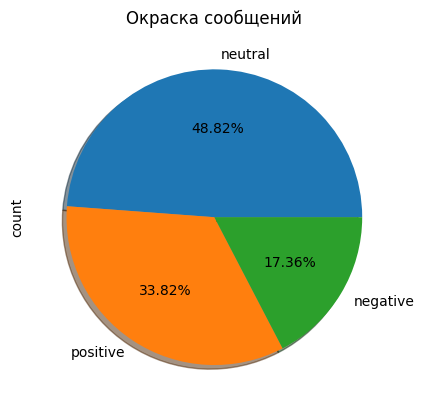

In [6]:
pd.Series(y_train).value_counts().plot.pie(title="Окраска сообщений", 
                                           legend=False,
                                           autopct='%1.2f%%',
                   shadow=True, startangle=0);

## Токенизация и кодирование классов


In [7]:
dict_size = 4_000 # размер словаря
dict_label = {'positive':1,
             'neutral':0,
             'negative':2}

In [8]:
X_train, y_train, X_val, y_val, vocab = prepare_data(X_train,y_train, X_val, y_val, dict_size, dict_label)

In [9]:
print(f'Длина словаря: {len(vocab)}')

Длина словаря: 4000


Сохраним словарь токенов для дальнейшего использования.

In [10]:
with open('saved_model/vocab.obj', 'wb') as f:
    pickle.dump(vocab, file=f)

## Длина токенизированных текстов

In [11]:
rev_len = [len(i) for i in X_train]

In [12]:
pd.Series(rev_len).describe()

count     7436.000000
mean       221.956697
std        541.816770
min          0.000000
25%         71.000000
50%        122.000000
75%        208.000000
max      23520.000000
dtype: float64

In [13]:
pd.Series(rev_len).quantile(0.90)

410.0

Разумно ограничить длину текста до 500 токенов.

## Добавление отбивки и ограничение размера строк

In [14]:
max_len = 500 # максимальная длина текста
X_train_pad = add_padding(X_train, max_len)
X_val_pad = add_padding(X_val, max_len)

## Создание загрузчиков данных

In [15]:
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val_pad), torch.from_numpy(y_val))

batch_size = 50 # размер батча

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

## Настройка модели

In [16]:
no_layers = 1
vocab_size = len(vocab) + 1
embedding_dim = 32 # размер вектора эмбединга
output_dim = 3 # число классов
hidden_dim = 32


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,
                     output_dim,
                     drop_prob=0.35)

model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(4001, 32, padding_idx=0)
  (lstm): LSTM(32, 32, batch_first=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)


## Обучение

In [17]:
lr=0.001 # скорость обучения

criterion = nn.CrossEntropyLoss() # лосс (кросс-энтропия со встроенным SoftMax)

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Оптимизатор


In [18]:
epochs = 10 
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    print('Обучение...')
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)   
        model.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels.long()) # расчёт функции потерь
        loss.backward() # обратный проходз - расчёт градиентов
        train_losses.append(loss.item())
        accuracy = acc(output,labels) # расчёт метрики
        train_acc += accuracy
        optimizer.step() # шаг оптимизации
       
    val_losses = []
    val_acc = 0.0
    model.eval() 
    print("Evaluating...")
    for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                output = model(inputs)
            val_loss = criterion(output, labels.long())
            val_losses.append(val_loss.item())          
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Эпоха {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc:.2%} val_accuracy : {epoch_val_acc:.2%}')
    if epoch_val_loss <= valid_loss_min: # если улучшился epoch_val_loss 
        torch.save(model, 'saved_model/lstm_model.pt') # сохраняем модель
        print(f'Потери на валидации уменьшились ({valid_loss_min:.6f} --> {epoch_val_loss:.6f}).  Сохранение модели...')
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 1
train_loss : 1.0409510455675572 val_loss : 1.0100614954443539
train_accuracy : 45.71% val_accuracy : 48.97%
Потери на валидации уменьшились (inf --> 1.010061).  Сохранение модели...
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 2
train_loss : 1.0067766868828127 val_loss : 1.0006130267592037
train_accuracy : 49.06% val_accuracy : 49.09%
Потери на валидации уменьшились (1.010061 --> 1.000613).  Сохранение модели...
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 3
train_loss : 0.9757714191539175 val_loss : 0.9558991334017586
train_accuracy : 50.26% val_accuracy : 51.63%
Потери на валидации уменьшились (1.000613 --> 0.955899).  Сохранение модели...
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 4
train_loss : 0.9148639252521847 val_loss : 0.909157437436721
train_accuracy : 54.33% val_accuracy : 54.41%
Потери на валидации уменьшились (0.955899 --> 0.909157).  Сохранение модели...
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 5
train_loss : 0.8536964090878532 val_loss : 0.884025678915136
train_accuracy : 58.96% val_accuracy : 56.23%
Потери на валидации уменьшились (0.909157 --> 0.884026).  Сохранение модели...
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 6
train_loss : 0.8014984918920786 val_loss : 0.8760869467959684
train_accuracy : 61.47% val_accuracy : 57.07%
Потери на валидации уменьшились (0.884026 --> 0.876087).  Сохранение модели...
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 7
train_loss : 0.769186267516757 val_loss : 0.8978718589333927
train_accuracy : 63.89% val_accuracy : 56.71%
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 8
train_loss : 0.7378548863750176 val_loss : 0.8652452125268824
train_accuracy : 66.54% val_accuracy : 57.68%
Потери на валидации уменьшились (0.876087 --> 0.865245).  Сохранение модели...
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 9
train_loss : 0.7014914269015293 val_loss : 0.8744268101804397
train_accuracy : 68.77% val_accuracy : 56.23%
Обучение...


  0%|          | 0/149 [00:00<?, ?it/s]

Evaluating...


  0%|          | 0/17 [00:00<?, ?it/s]

Эпоха 10
train_loss : 0.6596106690848433 val_loss : 0.9182943841990303
train_accuracy : 71.01% val_accuracy : 57.56%


## Кривые обучения

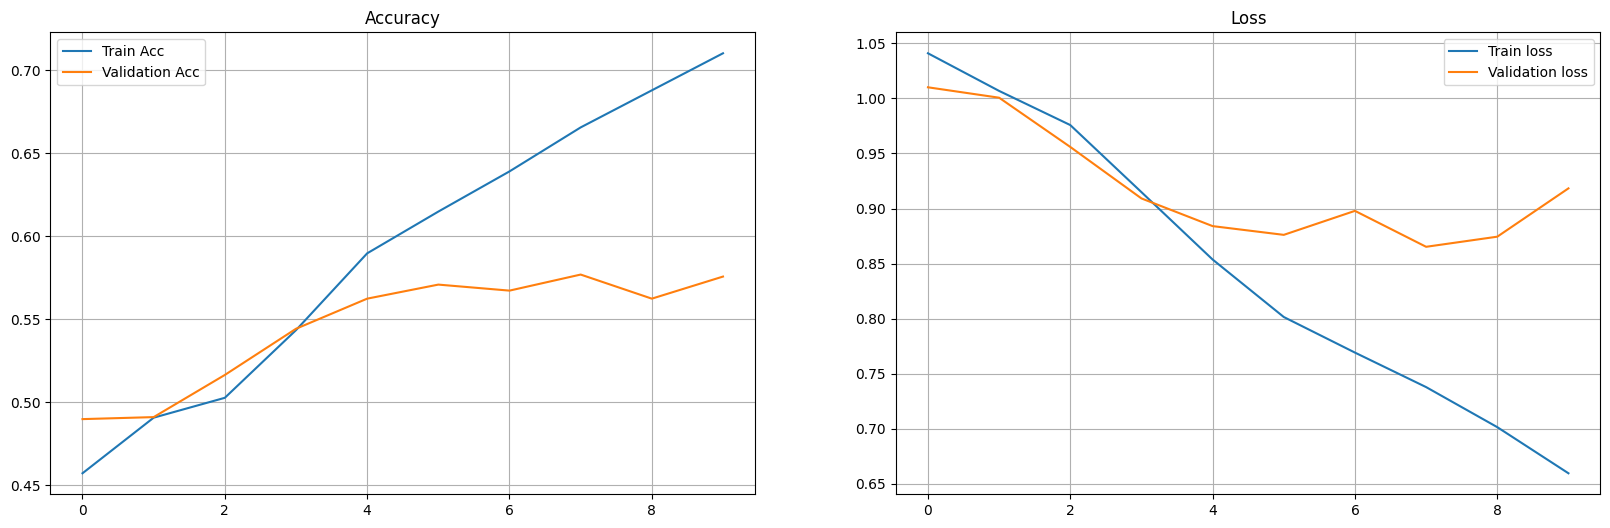

In [19]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

Выборка маловата и переобучение настигает рано.

## Загрузка модели

In [15]:
dict_cat = {v: k for k, v in dict_label.items()}
try:
    model = PdfCAPredictor("saved_model/lstm_model.pt", 
                            "saved_model/vocab.obj",
                            dict_cat, padding=500)
except (FileNotFoundError, ValueError) as e:
    print(e)

/home/lashkov/PycharmProjects/PdfCA/pdfcalib/model.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(checkpoint)


## Предсказание (тест)

In [16]:
text = 'На балконе спасатели обнаружили кота, который успел надышаться дымом и уже не подавал признаков жизни. Сотрудники провели успешную реанимацию животного и передали его хозяевам'

In [17]:
model.predict(text)

'positive'

## Предсказание (тест PDF)

In [34]:
text2 = pdf2text('example/anec.pdf', 1000)

In [35]:
text2

' 5\n \nВ ДЕТСКОМ  САДУ  \n \nОтец  приходит  за Вовочкой  в детский  сад. На первом  этаже  написа -\nно: «отличные  дети ». Вовочки  там не находит . Поднимается  на второй  \nэтаж : «Хорошие  дети ». Вовочки  там нет: Третий  этаж : «Плохие  дети ». И \nтам нет. Четвертый  этаж : «Ужастные  дети ». Вовочки  нет. Поднимается  \nна чердак . Там клетка , на клетке  надпись : «Вовочка ». \n \n* * * \n \nМаленький  мальчик  в детском  саду  впервые  увидел  голую  девочку : \n– Отъезали ? \n– Нет. \n– Отовалось ? \n– Нет. \n– А как? \nДевочка  вздыхает : \n– Так и было . \n \n* * * \n \nВо время  дневного  сна девочка  говорит  мальчику : \n – Давай  играть  в маму  и папу . \n – Давай . А как? \n – А ты ложись  рядом  со мной  и шепчи  мне на ухо. \n– А что шептать ? \n –А что хочешь . \nМальчик  шепчет . Девочка : \n – Нет, нет! Только  не сегодня , только  не сегодня ! Я устала  как со-\nбака . \n \n* * * \n \nДети , приходя  из детского  сада, стали  дома  после  еды говорить : \n«Му

In [36]:
model.predict(text2)

'positive'